In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Import dataset

In [2]:
df = pd.read_csv('./SRC/boston.csv', sep=',')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Training models

In [3]:
from numpy.random import randint

In [4]:
C = [2 ** i for i in range(-5, 16,2)]
gamma = [2 ** i for i in range(-15, 4,2)]

In [5]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'MLP 1layer': MLPRegressor(max_iter=4000),
    'MLP 2layer': MLPRegressor(max_iter=4000),
    'SVR Linear': SVR(kernel='linear'),
    'SVR Poly': SVR(kernel='poly', max_iter=10000)
}
params = {
    'RandomForestRegressor': {'n_estimators':[x for x in range(25, 500, 25)]},
    'SVR Poly': {'gamma':gamma, 'C':C , 'degree': [3, 5, 7, 9, 11], },
    'SVR Linear': {'gamma':gamma, 'C':C },
    'MLP 1layer': {'hidden_layer_sizes':[(x, ) for x in range(2,1000)]},
    'MLP 2layer': {'hidden_layer_sizes':[(randint(50,1000), randint(50,1000)) for x in range(2,1000)]},
}

In [6]:
def training_with_grid(models, params, df, y, normalizer, standardizer):
    
    df_results = {
        'Model':[],
        'Metric':[],
        'Params':[],
        'Processing':[],
        'Score':[]
    }
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[y]), df[y],test_size=0.25,shuffle=True)
    
    if normalizer:
        normalizer = Normalizer().fit(X_train)
        X_train = normalizer.transform(X_train)
        X_test = normalizer.transform(X_test)

    if standardizer:
        standardizer = StandardScaler().fit(X_train)
        X_train = standardizer.transform(X_train)
        X_test = standardizer.transform(X_test)
    
    processing = 'No'

    if normalizer:
        processing = 'Normalizer'

    if standardizer:
        processing = 'Standardizer'


    for name in models:
        model = RandomizedSearchCV(models[name], params[name], n_iter=5)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        
        df_results['Model'].append(name)
        df_results['Params'].append(model.best_params_)
        df_results['Processing'].append(processing)
        df_results['Score'].append(mean_absolute_error(y_test, y_predict))
        df_results['Metric'].append('MAE')
        df_results['Model'].append(name)
        df_results['Params'].append(model.best_params_)
        df_results['Processing'].append(processing)
        df_results['Score'].append(np.sqrt(mean_squared_error(y_test, y_predict)))
        df_results['Metric'].append('RMSE')
    return df_results

In [7]:
df_results = pd.DataFrame(training_with_grid(models, params, df, 'MEDV', None, None))
df_normalized = pd.DataFrame(training_with_grid(models, params, df,'MEDV', True, None))
df_standardizer = pd.DataFrame(training_with_grid(models, params, df,'MEDV', None, True))

/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScale

In [8]:
dataframe = pd.concat([df_results, df_normalized, df_standardizer],ignore_index=True)

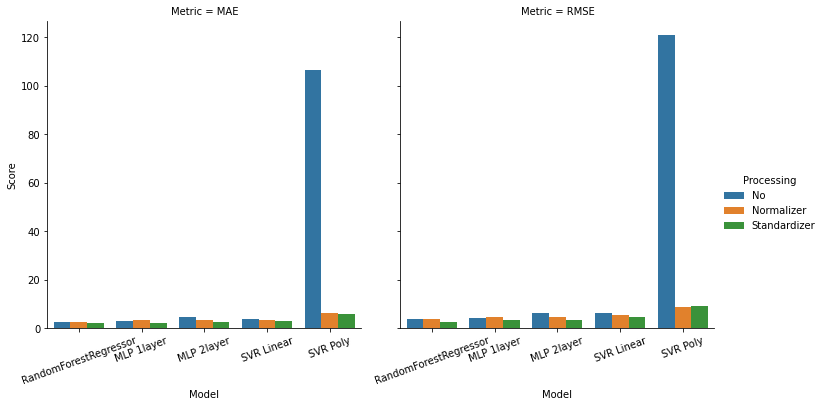

In [9]:
plot = sb.catplot(x='Model', y='Score',data=dataframe,col='Metric',hue='Processing', kind='bar')
for ax in plot.axes.flat:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

In general, better results were obtained when using normalization, although with twice the time for training and testing, it is interesting to apply it.

### Selecting features

I'm going to use the Randon Forest and MLP models, as they were the ones that did the best in the first practice.

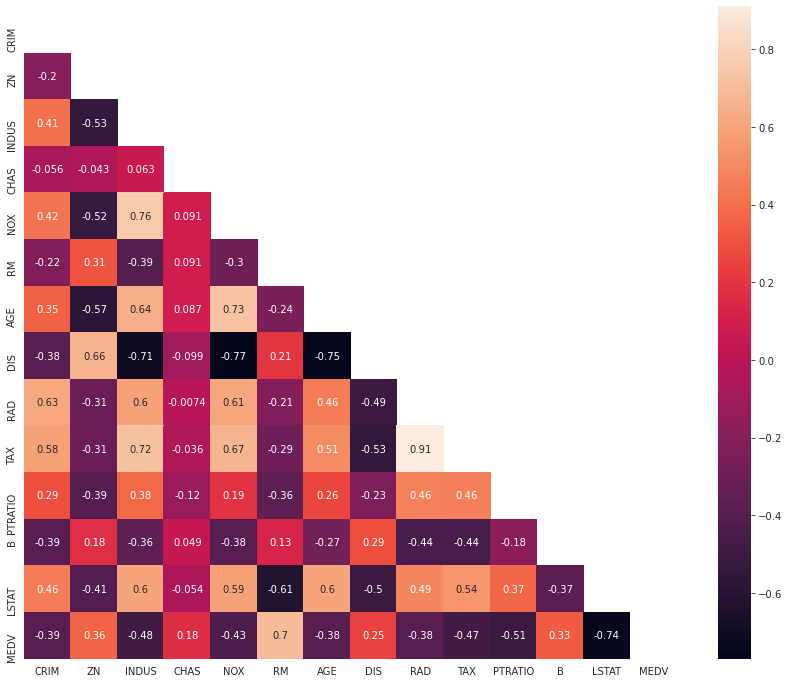

In [10]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sb.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15, 12));
    
    sb.heatmap(
        corr,
        ax=ax,
        annot=True,
        mask=mask,
        square=True
    );

The correlation matrix indicates that some features are not well correlated, such as DIS and B. I will apply the regression by taking these variables and comparing them later.

### Results

Excluding some features did not bring better results, however, the regressor model only with normalization processing and adjusting the hyper parameters is already good, so we can finish here.